In [ ]:
!pip install pyspark

In [ ]:
from tqdm import tqdm
import pandas as pd
import glob
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from google.colab import drive
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH
import os

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Lab5_Data.zip to Lab5_Data.zip


In [ ]:
import zipfile
import os

# Unzip
with zipfile.ZipFile("Lab5_Data.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Confirm the path exists
image_path = "Lab5_Data/Data/cars_train"
print("Path exists:", os.path.exists(image_path))


Path exists: True


In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), #Converts images to PyTorch tensors and scales pixel values to [0, 1]
])

In [ ]:
class ImageEmbeddingGenerator:
    def __init__(self):
        self.model = models.resnet18(pretrained=True)
        #put the model in evaluation mode
        self.model.eval()
        #remove last layer (the resnet is trained on 1000 classes so it will return a vector of size 1000 but we want size 512 so we remove last layer)
        self.model.fc = nn.Identity()

    def get_embedding(self, image):
        with torch.no_grad():
          #pytorch expects (batch_size, channels, height, width)
          #but we have a single image so the shape is (channels, height, width)
          #unsqueeze(0) transforms the shape to (1, channels, height, width) (batch size of 1)
            embedding = self.model(image.unsqueeze(0)).flatten()
        return embedding.cpu().numpy()


image_path = "Lab5_Data/Data/cars_train"


images = glob.glob(image_path + "/*.jpg")

print(len(images))



100


In [ ]:
generator = ImageEmbeddingGenerator()
embeddings = []

for image_path in tqdm(images):
    img = Image.open(image_path)
    embedding = generator.get_embedding(transform(img))
    embeddings.append(embedding)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]
100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


In [ ]:
import numpy as np

# Convert the list of numpy arrays into a single numpy array
embeddings = np.array(embeddings)

# Print the shape of the numpy array
print(embeddings.shape)


(100, 512)


In [ ]:
import pandas as pd
df = pd.DataFrame(embeddings, columns=[f"x{i}" for i in range(embeddings.shape[1])])
df['image'] = images

In [ ]:
df.to_csv('Lab5_Data/Data/cars_train_data.csv')

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('tp5').getOrCreate()

embeddings_df = spark.read.csv('Lab5_Data/Data/cars_train_data.csv', header=True, inferSchema=True)

In [ ]:
embeddings_df.show()

+---+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+----------+-----------+----------+----------+----------+------------+-----------+----------+----------+----------+----------+-----------+----------+------------+---------+-----------+----------+-----------+----------+---------+----------+----------+-----------+----------+----------+----------+------------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+----------+-----------+-----------+----------+----------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+------------+-----------+----------+-----------+-----------+----------+-----------+----------+-----------+-----------+-----------+----------+----------+-----------+-----------+----------+------------+----

In [ ]:
embeddings_df = embeddings_df.drop('_c0')

In [ ]:
from pyspark.ml.linalg import Vectors
# Combines all feature columns (x0, ..., x511) into a single vector column
assembler = VectorAssembler() \
  .setInputCols(embeddings_df.columns[:-1]) \
  .setOutputCol('vector')

In [ ]:
embeddings_df = assembler.transform(embeddings_df)

In [ ]:
embeddings_df.select(embeddings_df.vector).show(n=5)

+--------------------+
|              vector|
+--------------------+
|[0.60081774,1.603...|
|[1.0620283,1.6186...|
|[1.1953098,0.3830...|
|[2.0288444,1.4065...|
|[1.6970465,1.6212...|
+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import BucketedRandomProjectionLSH

lsh = BucketedRandomProjectionLSH(inputCol="vector", outputCol="lsh", bucketLength=512, numHashTables=4)
lshModel = lsh.fit(embeddings_df)

In [ ]:
embeddings_df = lshModel.transform(embeddings_df)

In [ ]:
embeddings_df.select('lsh').first()[0]

[DenseVector([0.0]),
 DenseVector([0.0]),
 DenseVector([-1.0]),
 DenseVector([0.0])]

In [ ]:
import random
random_index = random.randint(0, embeddings_df.count() - 1)
random_image = embeddings_df.select("image").collect()[random_index][0]
random_image

'Lab5_Data/Data/cars_train/00014.jpg'

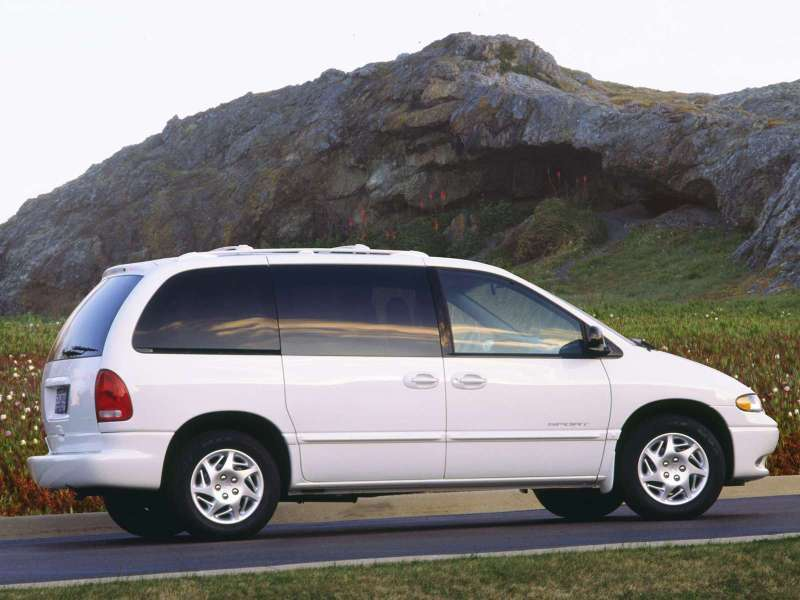

In [ ]:
random_img = Image.open(random_image)
random_img

In [ ]:
random_vector = generator.get_embedding(transform(random_img))

In [ ]:
neighbors = lshModel.approxNearestNeighbors(embeddings_df, Vectors.dense(random_vector), 5)

In [ ]:
neighbors.show()

+---------+---------+---------+----------+---------+----------+----------+----------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+---------+---------+---------+----------+----------+----------+----------+---------+----------+-----------+----------+----------+----------+---------+------------+----------+----------+----------+----------+---------+---------+---------+-----------+----------+----------+----------+-----------+----------+----------+----------+----------+---------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+----------+----------+----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+-------

In [ ]:
neighbors_names = [row.image for row in neighbors.select(neighbors.image).collect()]

In [ ]:
print(neighbors_names)

['Lab5_Data/Data/cars_train/00014.jpg', 'Lab5_Data/Data/cars_train/00045.jpg', 'Lab5_Data/Data/cars_train/00086.jpg', 'Lab5_Data/Data/cars_train/00077.jpg', 'Lab5_Data/Data/cars_train/00026.jpg']


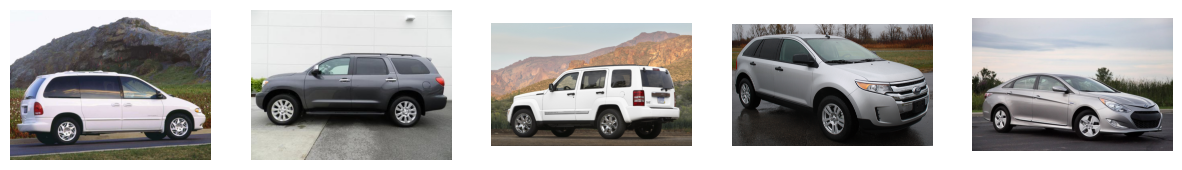

In [ ]:
def display_images(names: list[str]) -> None:
    fig, axes = plt.subplots(ncols=len(names), nrows=1)
    fig.set_size_inches(15, 8)

    for name, ax in zip(names, axes):
        img = Image.open(name)
        ax.imshow(img)
        ax.axis('off')

display_images(neighbors_names)